## <font size = "5" color="white" style="font-family:'Courier New'" >Tensorflow 2.0 CELEB DATASET segmentation Notebook</font>
## <font size = "4" color="red" style="font-family:'Courier New'" >Dependencies and libraries</font>

In [2]:
import numpy as np
from glob import glob
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Nadam
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping,TensorBoard
%matplotlib inline

print(tf.__version__)
print(f"Build with CUDA : {tf.test.is_built_with_cuda()}")
print(f"GPU detected : {tf.test.is_gpu_available()}")

import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config)

2.0.0-beta0
Build with CUDA : True
GPU detected : True


## <font size = "4" color="red" style="font-family:'Courier New'" >Data set pipeline </font>

In [3]:
"""data list makes"""
def pass_asserts():
    assert len(train_image) == len(train_mask)
    assert len(val_image) == len(val_mask)
    print("PASSED")
    
train_image = sorted(glob("CELEB/train_images/*jpg"))
train_mask = sorted(glob("CELEB/train_masks/*png"))
val_image = sorted(glob("CELEB/val_images/*jpg"))
val_mask = sorted(glob("CELEB/val_masks/*png"))
PROBS = {"CONTRAST" : 0.7,"PAD_AND_CROP":0.6,"SATURATION":0.7}

def normalize_image(image,mask):
    im_proc = tf.cast(image,tf.float32)/ 255.
    ma_proc = tf.cast(mask,tf.float32)
    return im_proc,ma_proc

def change_il(image):
    if tf.random.uniform(())>PROBS["CONTRAST"]:
        im_proc = tf.image.random_contrast(image,lower=0.3,upper=0.6)
    if tf.random.uniform(())>PROBS["SATURATION"]:
        im_proc = tf.image.random_saturation(image,lower=0.3,upper=0.6)
    else:
        im_proc = image
    return im_proc


@tf.function
def load_data(image,mask):
    try:
        im_proc = tf.io.read_file(image)
        ma_proc = tf.io.read_file(mask)

        im_proc = tf.image.decode_jpeg(im_proc)
        ma_proc = tf.image.decode_jpeg(ma_proc)
        ma_proc = tf.image.rgb_to_grayscale(ma_proc)
        im_proc = change_il(im_proc)
        image,mask = normalize_image(im_proc,ma_proc)
    except:
        print(image)
        pass
    if tf.random.uniform(()) > PROBS["PAD_AND_CROP"]:
        im_proc = tf.image.resize_with_crop_or_pad(image,target_height=350,target_width=350)
        ma_proc = tf.image.resize_with_crop_or_pad(mask,target_height=350,target_width=350)
    else:
        im_proc = tf.image.resize(image,size=(350,350))
        ma_proc = tf.image.resize(mask,size=(350,350))
    return im_proc,ma_proc


def load_val(image,mask):
    try:
        im_proc = tf.io.read_file(image)
        ma_proc = tf.io.read_file(mask)

        im_proc = tf.image.decode_jpeg(im_proc)
        ma_proc = tf.image.decode_jpeg(ma_proc)
        ma_proc = tf.image.rgb_to_grayscale(ma_proc)
        im_proc = tf.image.resize(im_proc,size=(350,350))
        ma_proc = tf.image.resize(ma_proc,size=(350,350))
        image,mask = normalize_image(im_proc,ma_proc)
        return image,mask
    except:
        print(image)
        pass
    
BUFFER = len(train_image)
BATCH_SIZE=8
TRAIN = tf.data.Dataset.from_tensor_slices((train_image,train_mask))
VAL = tf.data.Dataset.from_tensor_slices((val_image,val_mask))

TRAIN = TRAIN.map(load_data,num_parallel_calls=tf.data.experimental.AUTOTUNE)
VAL = VAL.map(load_val,num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_ = TRAIN.batch(BATCH_SIZE,drop_remainder=True).repeat()
val_ = VAL.batch(BATCH_SIZE,drop_remainder=True).repeat()
train_ = TRAIN.batch(BATCH_SIZE,drop_remainder=True).repeat()
val_ = VAL.batch(BATCH_SIZE,drop_remainder=True).repeat()

## <font size = "4" color="red" style="font-family:'Courier New'" >Verify the pipeline </font>

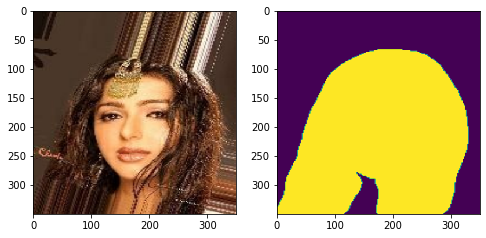

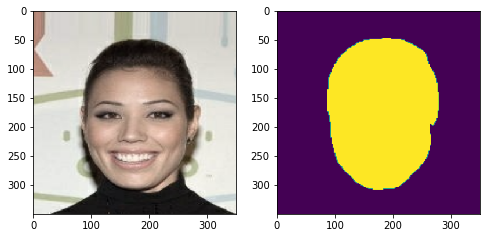

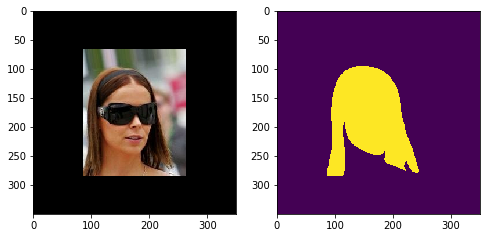

In [4]:
images = []
masks  =  []
for image,mask in train_.take(3):
    plt.figure(figsize=(8,8))
    plt.subplot(1,2,1)
    plt.imshow(image[0])
    plt.subplot(1,2,2)
    plt.imshow(mask[0][:,:,-1])

## <font size = "5" color="red" style="font-family:'Courier New'" >Model Building </font>
## <font size = "4" color="red" style="font-family:'Courier New'" >code your UNET architecture </font>

In [5]:
def upscale_block(inpx,upsamp_val,prevx,t_filt,conv1=False):
    if conv1:
        xa = tf.image.resize(inpx,upsamp_val)
        xa = Conv2D(512,1,padding="same")(xa)
        xa = BatchNormalization(axis=-1)(xa)
        xa = Activation("relu")(xa)
        xb = Conv2D(512,1,padding="same")(prevx)
        xb = BatchNormalization(axis=-1)(xb)
        xb = Activation("relu")(xb)
        xconc = concatenate([xa,xb],axis=3)
        xaxb = Conv2D(t_filt,3,padding="same")(xconc)
        xaxb = BatchNormalization(axis=-1)(xaxb)
        xaxb = Activation("relu")(xaxb)
    else:
        xa = tf.image.resize(inpx,upsamp_val)
        xconc = concatenate([xa,prevx],axis=3)
        xaxb = Conv2D(t_filt,3,padding="same")(xconc)
        xaxb = BatchNormalization(axis=-1)(xaxb)
        xaxb = Activation("relu")(xaxb)
    return xaxb

def UNET(classes):
    base_model = tf.keras.applications.ResNet50(include_top=False,input_shape=(350,350,3))
    for layer in base_model.layers:
        layer.traiable = True
    a1 = base_model.get_layer("activation").output  
    f1 = base_model.get_layer("activation_2").output   
    f2 = base_model.get_layer("activation_20").output   
    f3 = base_model.get_layer("activation_31").output 
    f4 = base_model.get_layer("activation_36").output  
    f5 = base_model.get_layer("activation_42").output  
    
    u5 = upscale_block(f5,(22,22),f4,512,conv1=True)
    u4 = upscale_block(u5,(22,22),f3,256)
    u3 = upscale_block(u4,(44,44),f2,128)
    u2 = upscale_block(u3,(88,88),f1,64)
    u1 = upscale_block(u2,(175,175),a1,64)
    
    u1 = tf.image.resize(u1,(350,350))
    au1 = Conv2D(32,3,padding="same")(u1)
    au1 = BatchNormalization(axis=3)(au1)
    au1 = PReLU(shared_axes=[1,2])(au1)
    
    au1 = Conv2D(classes,1,padding="same")(au1)
    au1 = Activation("softmax")(au1)
    build = Model(inputs=base_model.input,outputs=au1)
    return build

## <font size = "4" color="red" style="font-family:'Courier New'" >start training</font>

In [6]:
model_ckpt = ModelCheckpoint("weightdelete.h5",monitor="val_loss",verbose=1,save_weights_only=True)
es_log = EarlyStopping(monitor="val_loss",patience=5)
tb_log = TensorBoard("save_celeb/")
cbs = [model_ckpt,es_log,tb_log]
model = UNET(3)
model.compile(optimizer=Nadam(1e-4), loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.fit(train_,epochs=3,steps_per_epoch=len(train_image)//BATCH_SIZE,validation_data=val_,validation_steps=len(val_image)//BATCH_SIZE,callbacks=cbs)

/usr/local/lib/python3.6/dist-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


Epoch 1/3
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
434/435 [============================>.] - ETA: 0s - loss: 0.2664 - accuracy: 0.9480
Epoch 00001: saving model to weightdelete.h5
435/435 [==============================] - 158s 363ms/step - loss: 0.2661 - accuracy: 0.9480 - val_loss: 1.1163 - val_accuracy: 0.5848
Epoch 2/3
434/435 [============================>.] - ETA: 0s - loss: 0.1261 - accuracy: 0.9696
Epoch 00002: saving model to weightdelete.h5
435/435 [==============================] - 118s 270ms/step - loss: 0.1260 - accuracy: 0.9697 - val_loss: 0.1446 - val_accuracy: 0.9535
Epoch 3/3
434/435 [============================>.] - ETA: 0s - loss: 0.0921 - accuracy: 0.9718
Epoch 00003: saving model to weightdelete.h5
435/435 [==============================] - 118s 270ms/step - loss: 0.0920 - accuracy: 0.9718 - val_loss: 0.0911 - val_accuracy: 0.9650


## <font size = "4" color="red" style="font-family:'Courier New'" >Testing the model </font>

In [44]:
load_ckpt = model.load_weights("weight.h5")
from tensorflow.keras.preprocessing.image import  load_img,img_to_array
import cv2
import scipy
def Inference(im_file):
    plt.figure(figsize=(10,10))
    Image_file = im_file
    load_file = load_img(Image_file,target_size=(350,350))
    load_file = img_to_array(load_file) / 255.
    load_file = np.expand_dims(load_file,axis=0)
    mask_     = model.predict(load_file)
    mask_     = np.argmax(mask_>= 0.97,axis=-1)
    mask_     = np.squeeze(mask_)
    load_image    = cv2.imread(Image_file)
    raw           = cv2.cvtColor(load_image,cv2.COLOR_BGR2RGB)
    plt.subplot(1,2,1)
    plt.imshow(raw)
    height ,width = load_image.shape[0],load_image.shape[1]
    newmask       = scipy.ndimage.zoom(mask_, (height/350,width/350), order=1, mode='nearest')
    load_image[newmask==0] = [0,0,0]
    load_image = cv2.cvtColor(load_image,cv2.COLOR_BGR2RGB)
    plt.subplot(1,2,2)
    plt.imshow(load_image)
   

## <font size = "6" color="green" style="font-family:'Courier New'" >Results on random google images</font>

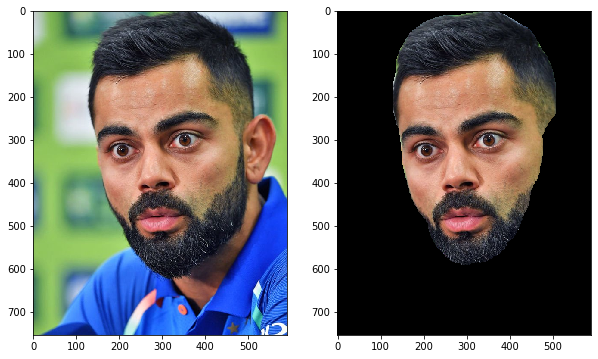

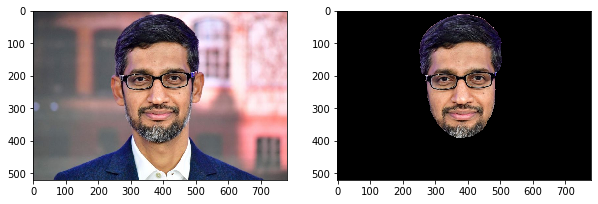

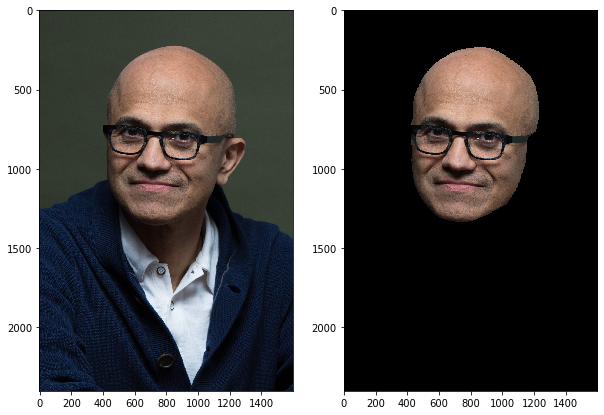

In [51]:
Inference("Virat-Kohli-1728794.jpg")
Inference("files-us-it-lifestyle-google-alphabet-195736.jpg")
Inference("sn.jpg")

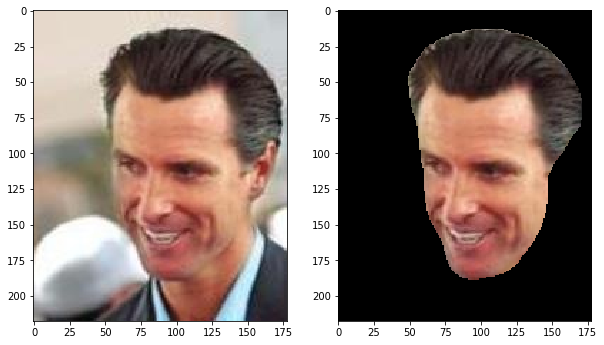

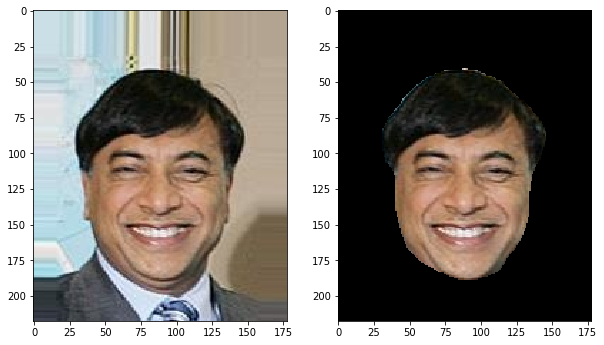

In [52]:
#validation test analysis
Inference("CELEB/val_images/000070.jpg")
Inference("CELEB/val_images/000072.jpg")